In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

We did forecasts on 7 * 3 * 5 = 105 datasets (6 targets + 1 source, 3 OSDs and 5 runs). Here, we average the performance metrics, similarities and features to evaluate the averaged results over div steps (=OSDs) and runs.

In [ ]:
path_to_evaluation = "/home/dev/projects/evaluation/data/evaluation/" # where to save the averaged results

In [ ]:
# adjust the path_to_forecasts in this cell to your data structure

point_metrics = ["NRMSE", "MASE", "sMAPE"]
all_metrics = []

for run in ["run1", "run2", "run3", "run4", "run5"]:
    path_to_forecasts = f"/home/dev/projects/data/{run}/outputs/forecasts/" #adjust
    for div_step in [10,5,0]: 
        mets = pd.read_parquet(path_to_forecasts + "evaluation/metrics_div_step" + str(div_step) + ".parquet")
        mets['div_step'] = div_step
        mets['run'] = run
        all_metrics.append(mets)
        all_metrics_df = pd.concat(all_metrics, ignore_index=True)
all_metrics_df.to_csv(path_to_evaluation+"results.csv")

In [ ]:
# build the mean and the sd over runs and div steps
custom_order = ["5000", "12000", "25000", "50000", "100000", "all", "source"]
all_metrics_df.drop(columns=["div_step"], inplace=True)

all_metrics_df['pot target size'] = pd.Categorical(all_metrics_df['pot target size'], categories=custom_order, ordered=True)
agg_funcs = {
    'RMSSE': ['mean', 'std'],
    'MASE': ['mean', 'std'],
    'sMAPE': ['mean', 'std'],
    'similarity': ['mean', 'std'],
    'intermittency': ['mean', 'std'],
    'erraticness': ['mean', 'std']
}

result = all_metrics_df.groupby("pot target size").agg(agg_funcs)

formatted_result = result.apply(
    lambda x: [
        f"{x[col][0]:.2f} ({x[col][1]:.2f})" if col in ['similarity', 'intermittency', 'erraticness'] else f"{x[col][0]:.2f} ({x[col][1]:.2f})"
        for col in result.columns.levels[0]
    ], axis=1
)

formatted_df = pd.DataFrame(formatted_result.tolist(), columns=result.columns.levels[0], index=result.index)

# Sort by 'pot target size'
formatted_df = formatted_df.sort_index()
formatted_df.reset_index(inplace=True)
formatted_df["test set"] = ["target", "target", "target", "target", "target", "target", "source"]
formatted_df = formatted_df[["test set", "pot target size", "similarity", "intermittency", "erraticness", "RMSSE", "MASE", "sMAPE"]]

print(formatted_df)
formatted_df.to_csv(path_to_evaluation + "results_averaged.csv", index=False)

  test set pot target size   similarity intermittency  erraticness  \
0   target            5000  7.04 (0.01)   1.04 (0.00)  4.65 (0.07)   
1   target           12000  7.24 (0.02)   1.19 (0.01)  5.77 (0.15)   
2   target           25000  8.08 (0.02)   1.22 (0.02)  7.31 (0.20)   
3   target           50000  8.25 (0.03)   1.16 (0.01)  7.03 (0.22)   
4   target          100000  9.34 (0.03)   1.39 (0.02)  3.56 (0.17)   
5   target             all  9.73 (0.04)   1.32 (0.02)  4.62 (0.17)   
6   source          source    nan (nan)   1.34 (0.00)  4.43 (0.02)   

         RMSSE         MASE        sMAPE  
0  0.47 (0.03)  0.73 (0.01)  0.31 (0.00)  
1  0.39 (0.04)  0.61 (0.02)  0.31 (0.00)  
2  0.37 (0.04)  0.58 (0.02)  0.33 (0.01)  
3  0.38 (0.04)  0.60 (0.01)  0.33 (0.00)  
4  0.61 (0.02)  0.82 (0.01)  0.39 (0.01)  
5  0.54 (0.03)  0.75 (0.01)  0.38 (0.00)  
6  0.55 (0.02)  0.76 (0.01)  0.38 (0.00)  


Plot the erraticness against the RMSSE and MASE and the intermittency against the sMAPE. Fit a linear line and calculate the slope and p-value.

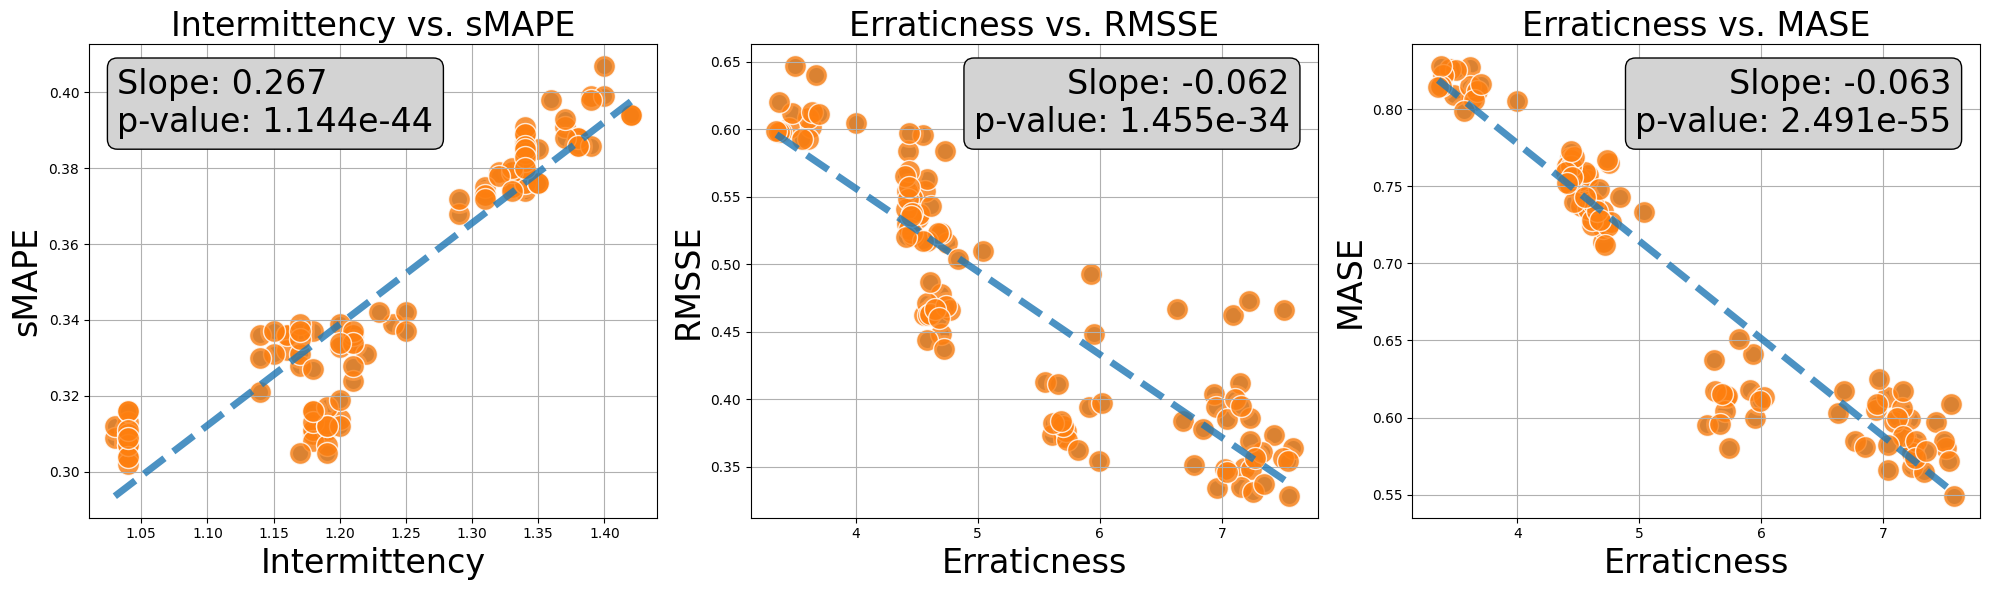

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
df = all_metrics_df

def plot_linear_fit(ax, x, y, metric):
    if len(x) > 1:
        # Linear regression
        linear_coeffs = np.polyfit(x, y, deg=1)  # Linear fit
        linear_eq = np.poly1d(linear_coeffs)
        x_fit = np.linspace(min(x), max(x), 100)
        y_fit = linear_eq(x_fit)
        
        # Scatter plot and linear fit line
        ax.plot(x_fit, y_fit, linestyle="--", alpha=0.8, linewidth=5)
        ax.scatter(x, y, s=250, edgecolors="w", alpha=0.8)  

        # Calculate p-value
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

        # Determine annotation position based on the metric
        if metric == 'sMAPE':
            ax.annotate(f"Slope: {slope:.3f}\np-value: {p_value:.3e}",
                        xy=(0.05, 0.95), xycoords='axes fraction', fontsize=24,
                        ha='left', va='top', 
                        bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightgray'))
        elif metric in ['RMSSE', 'MASE']:
            ax.annotate(f"Slope: {slope:.3f}\np-value: {p_value:.3e}",
                        xy=(0.95, 0.95), xycoords='axes fraction', fontsize=24,  
                        ha='right', va='top', 
                        bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='lightgray'))

# Scatter plot: Intermittency vs. sMAPE
axes[0].scatter(
    df["intermittency"], df["sMAPE"], alpha=0.8, edgecolors="w", s=250, linewidth=5  
)
plot_linear_fit(axes[0], df["intermittency"], df["sMAPE"], "sMAPE")
axes[0].set_xlabel("Intermittency", fontsize=24)  
axes[0].set_ylabel("sMAPE", fontsize=24)  
axes[0].set_title("Intermittency vs. sMAPE", fontsize=24) 
axes[0].grid(True)

# Scatter plot: Erraticness vs. RMSSE
axes[1].scatter(
    df["erraticness"], df["RMSSE"], alpha=0.8, edgecolors="w", s=250, linewidth=5 
)
plot_linear_fit(axes[1], df["erraticness"], df["RMSSE"], "RMSSE")
axes[1].set_xlabel("Erraticness", fontsize=24)  
axes[1].set_ylabel("RMSSE", fontsize=24)  
axes[1].set_title("Erraticness vs. RMSSE", fontsize=24)  
axes[1].grid(True)

# Scatter plot: Erraticness vs. MASE
axes[2].scatter(
    df["erraticness"], df["MASE"], alpha=0.8, edgecolors="w", s=250, linewidth=5  
)
plot_linear_fit(axes[2], df["erraticness"], df["MASE"], "MASE")
axes[2].set_xlabel("Erraticness", fontsize=24)  
axes[2].set_ylabel("MASE", fontsize=24)  
axes[2].set_title("Erraticness vs. MASE", fontsize=24) 
axes[2].grid(True)

plt.tight_layout()
plt.savefig(path_to_evaluation + f"linear_fit.pdf")
plt.show()